# Spectrum Plots

This notebook makes the spectral plots for the manuscript CFB on EBF.
Author: Jacob Wenegrat (wenegrat@umd.edu).



In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import xarray as xr
import xgcm
from glob import glob
from dask.diagnostics import ProgressBar
import sys
import matplotlib.patches as patches
sys.path.append('/homes/metofac/wenegrat/xroms/')


#from xroms import open_roms_netcdf_dataset
import cmocean.cm as cmo
import xroms
from scipy import integrate as integrate
from timeit import default_timer as timer
    
import xrft
from importlib import reload  
import sys
sys.path.append("../src/")
import load_model_runs as lruns
#%%
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'

from dask.distributed import Client


In [16]:
client = Client()
client

/homes/metofac/wenegrat/.conda/envs/CFB_EBF_3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34964 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34964/status,
Dashboard: http://127.0.0.1:34964/status,Workers: 16
Total threads: 128,Total memory: 503.40 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44673,Workers: 16
Dashboard: http://127.0.0.1:34964/status,Total threads: 128
Started: Just now,Total memory: 503.40 GiB
Comm: tcp://127.0.0.1:33927,Total threads: 8
Dashboard: http://127.0.0.1:33595/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:46175,


In [21]:
## LOAD THE NEW RUNS
reload(lruns)
dsWC, gridWC = lruns.newLoad('../data/model/JET_NML_CFB_BFLUX/', chunks={'time':1})
# dsWC, gridWC = lruns.newLoad('../data/model/JET_NML_CFB/', chunks={'time':1})

#dsWC['f'] = dsOLD.f

reload(lruns)
dsNC, gridNC = lruns.newLoad('../data/model/JET_NML_NOCFB_BFLUX/', chunks={'time':1})
# dsNC, gridNC = lruns.newLoad('../data/model/JET_NML_NOCFB/', chunks={'time':1})

#dsNC['f'] = dsOLD.f

folder = '/data/pacific/jacob/CFB/cfb_on_ebf/figures/jet_ml_figs/'

In [22]:
# Set Time Range

# days = slice(5,10)

## Calculations

In [ ]:
# Calculate KE spectra
yl = slice(400, 3600)
u = xroms.to_rho(dsWC.u, gridWC).isel(s_rho=-1).chunk(chunks={'ocean_time':1, 'eta_rho':4002, 'xi_rho':1002}).isel(eta_rho=yl)
u['xi_rho'] = u.xi_rho*500 # convert to physical dimensions (m)
u['eta_rho'] = u.eta_rho*500

v = xroms.to_rho(dsWC.v.isel(s_rho=-1), gridWC).chunk(chunks={'ocean_time':1, 'eta_rho':4002, 'xi_rho':1002}).isel(eta_rho=yl)
v['xi_rho'] = v.xi_rho*500
v['eta_rho'] = v.eta_rho*500

u_nc = xroms.to_rho(dsNC.u.isel(s_rho=-1), gridNC).chunk(chunks={'ocean_time':1, 'eta_rho':4002, 'xi_rho':1002}).isel(eta_rho=yl)
u_nc['xi_rho'] = u_nc.xi_rho*500
u_nc['eta_rho'] = u_nc.eta_rho*500
v_nc = xroms.to_rho(dsNC.v.isel(s_rho=-1), gridNC).chunk(chunks={'ocean_time':1, 'eta_rho':4002, 'xi_rho':1002}).isel(eta_rho=yl)
v_nc['xi_rho'] = v_nc.xi_rho*500
v_nc['eta_rho'] = v_nc.eta_rho*500


density = True
# Calculate the PSD
uiso2 = xrft.isotropic_power_spectrum(u, dim=['xi_rho', 'eta_rho'], detrend='linear', window=True, nfactor=1, truncate=True, density=density)
viso2 = xrft.isotropic_power_spectrum(v, dim=['xi_rho', 'eta_rho'], detrend='linear', window=True, nfactor=1, truncate=True, density=density)
#uspec = xrft.power_spectrum(u, dim=['xi_rho', 'eta_rho'])
eke = 0.5*(uiso2 + viso2)

uiso2_nc = xrft.isotropic_power_spectrum(u_nc, dim=['xi_rho', 'eta_rho'], detrend='linear', window=True, nfactor=1, truncate=True, density=density)
viso2_nc = xrft.isotropic_power_spectrum(v_nc, dim=['xi_rho', 'eta_rho'], detrend='linear', window=True, nfactor=1, truncate=True, density=density)
#uspec = xrft.power_spectrum(u, dim=['xi_rho', 'eta_rho'])
eke_nc = 0.5*(uiso2_nc + viso2_nc)

eke

/homes/metofac/wenegrat/.conda/envs/CFB_EBF_3/lib/python3.10/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


In [ ]:
# Calculate surface buoyancy spectra
nfactor = 1

b = -9.8/1020*dsWC.rho.isel(s_rho=-1).isel(eta_rho=yl)
b['xi_rho'] = b.xi_rho*500
b['eta_rho'] = b.eta_rho*500
b=b.drop(['x_rho', 'y_rho', 'z_rho', 'z_rho0'])
b_iso = xrft.isotropic_power_spectrum(b, dim=['xi_rho', 'eta_rho'], detrend='linear', window='hamming', nfactor=nfactor, truncate=True, density=density)
b_iso


b_nc = -9.8/1020*dsNC.rho.isel(s_rho=-1).isel(eta_rho=yl)
b_nc['xi_rho'] = b_nc.xi_rho*500
b_nc['eta_rho'] = b_nc.eta_rho*500
b_nc=b_nc.drop(['x_rho', 'y_rho', 'z_rho', 'z_rho0'])
b_iso_nc = xrft.isotropic_power_spectrum(b_nc, dim=['xi_rho', 'eta_rho'], detrend='linear', window='hamming', nfactor=nfactor, truncate=True, density=density)
b_iso_nc

In [ ]:
# Take mean of EKE over day range
days = slice(20,30)

ekem = eke.isel(ocean_time=days).mean('ocean_time')
ekem

ekem_nc = eke_nc.isel(ocean_time=days).mean('ocean_time')

b_iso_m = b_iso.isel(ocean_time=days).mean('ocean_time')
b_iso_nc_m = b_iso_nc.isel(ocean_time=days).mean('ocean_time')

In [ ]:
# Calculate Ogives
nf = np.argmin(np.abs(ekem.freq_r.values - 1e-3))
nf = 707
og = -integrate.cumtrapz(ekem.values[0:nf],x=ekem.freq_r.values[0:nf], initial=0) +  integrate.trapz(ekem.values[0:nf], x=ekem.freq_r[0:nf])
og_NC = -integrate.cumtrapz(ekem_nc.values[0:nf],x=ekem_nc.freq_r.values[0:nf], initial=0) +  integrate.trapz(ekem_nc.values[0:nf], x=ekem_nc.freq_r[0:nf])

k = b_iso_m.freq_r
b_og = -integrate.cumtrapz(b_iso_m.values[0:nf]*k**2,x=b_iso_m.freq_r.values[0:nf], initial=0) +  integrate.trapz(b_iso_m.values[0:nf]*k**2, x=b_iso_m.freq_r[0:nf])
b_og_nc = -integrate.cumtrapz(b_iso_nc_m.values[0:nf]*k**2,x=b_iso_nc_m.freq_r.values[0:nf], initial=0) +  integrate.trapz(b_iso_nc_m.values[0:nf]*k**2, x=b_iso_nc_m.freq_r[0:nf])






## PLOTS

2023-01-06 16:33:59,141 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-06 16:34:03,652 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-06 16:34:07,636 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-06 16:34:12,146 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


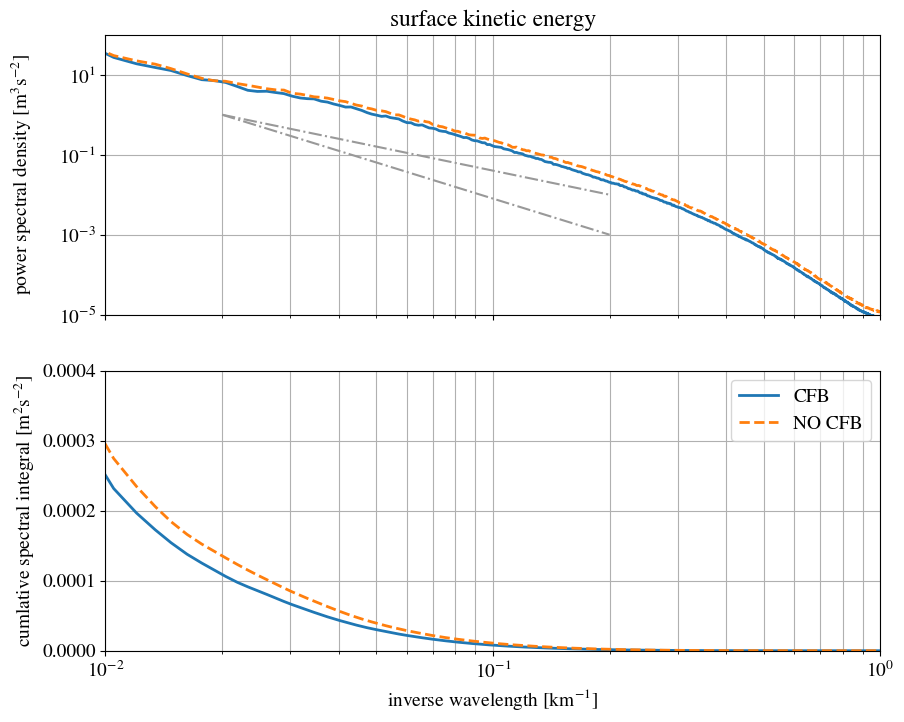

2023-01-06 16:34:16,158 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-06 16:34:20,652 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-06 16:34:24,650 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-01-06 16:34:28,649 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-06 16:34:33,139 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-06 16:34:37,159 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-06 16:34:41,641 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-01-06 16:34:45,651 - distributed.utils_perf - WARNING - full garbage collections took

In [14]:
########## KE SPECTRA AND OGIVE ###############
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

ax[0].loglog(ekem.freq_r*1000, ekem, linewidth=2)
ax[0].loglog(ekem_nc.freq_r*1000, ekem_nc, linewidth=2, linestyle='--')
ax[0].set_xlim(1e-2, 1)
ax[0].set_ylim(1e-5, 1e2)
ax[0].tick_params(axis='y', which='both')

ax[0].grid(which='both')
ax[0].set_ylabel('power spectral density [m$^3$s$^{-2}$]', labelpad=17.5)
#add slope lines

k3 = np.array([2e-2,2e-1])
E3 = 1/k3**3
E3 = E3/E3[0]*(1e0)
E2 = k3*E3
E2 = E2/E2[0]*E3[0]
E1 = k3*E2
E1 = E1/E1[0]*E3[0]
ax[0].plot(k3, E2, linestyle='-.', color='0.6')
ax[0].plot(k3, E3, linestyle='-.', color='0.6')

ax[1].plot(ekem.freq_r[0:nf]*1000, og, linewidth=2, label='CFB')
ax[1].plot(ekem.freq_r[0:nf]*1000, og_NC, linewidth=2, linestyle='--', label='NO CFB')
ax[1].grid(which='both')
ax[1].set_ylim(0, 4e-4)
# ax[1].set_ylim(1e-11, 1e-3)
ax[1].set_ylabel('cumlative spectral integral [m$^2$s$^{-2}$]')
ax[1].set_xlabel('inverse wavelength [km$^{-1}]$')
ax[1].legend()

ax[0].set_title('surface kinetic energy')

# plt.savefig('../figures/SurfaceKEOgive_NOFLUX.pdf', bbox_inches='tight')

In [9]:
# Print out some values for the manuscript
ind = np.argmin(np.abs(ekem.freq_r.values - 1e-2)) # find the indices of 100 km
diff = (og-og_NC)/og_NC
ind = np.argmax(np.abs(diff[:-20]))
print(ekem.freq_r.values[ind])
print(f'Percent change in surface KE: {(og[ind]-og_NC[ind])/og_NC[ind]}') # print out the percentage change of EKE
ind = np.argmin(np.abs(b_iso_m.freq_r.values*1000 - 1e-2)) # find the indices of 100 km
print(f'Percent change in surface Grad B: {(b_og[ind]-b_og_nc[ind])/b_og_nc[ind]}') # print out the percentage change of EKE


0.0009689186532810003
Percent change in surface KE: -0.3095685177644423
Percent change in surface Grad B: -0.033006386991276795


## EXPLORATORY STUFF

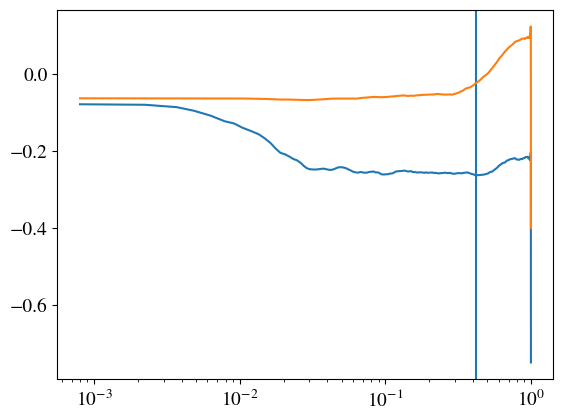

In [158]:
ind = np.argmax(np.abs(diff[:-20]))

plt.semilogx(ekem.freq_r, diff)
plt.axvline(ekem.freq_r[ind])

plt.semilogx(b_iso_m.freq_r*1000, (b_og-b_og_nc)/b_og_nc)

Text(0.5, 0, 'km$^{-1}$')

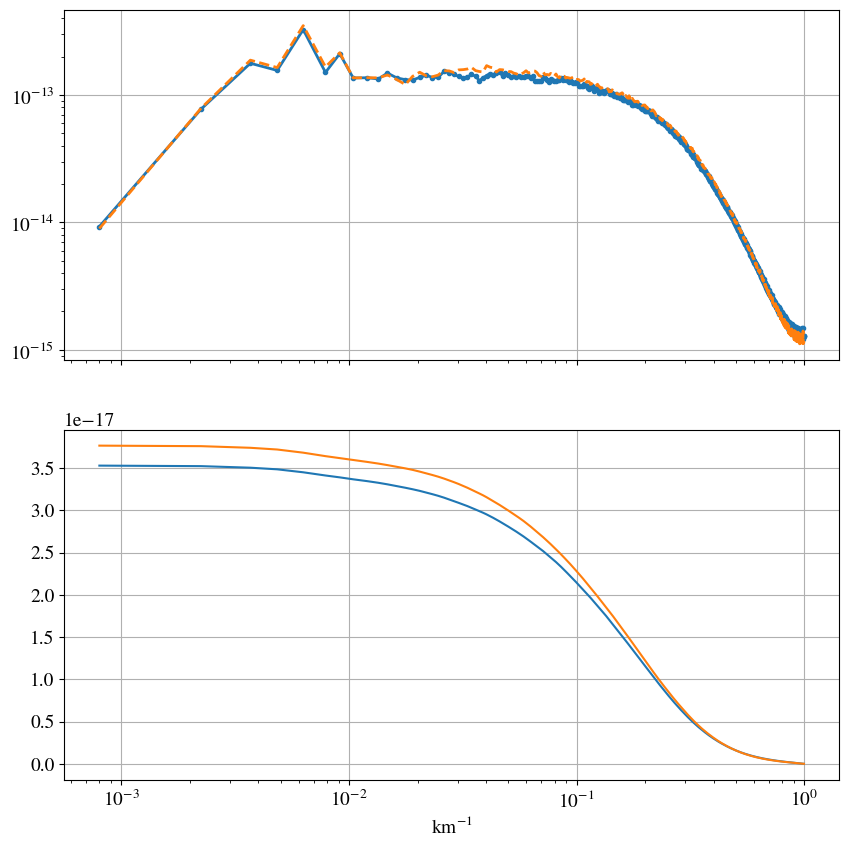

In [112]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

k = b_iso_m.freq_r
ax[0].loglog(b_iso_m.freq_r*1000, b_iso_m*k**2, linewidth=2, marker='.')
ax[0].loglog(b_iso_nc_m.freq_r*1000, b_iso_nc_m*k**2, linewidth=2, linestyle='--')
#ax[0].set_xlim(1e-3, 1)
ax[0].grid()

#add slope lines

k3 = np.array([2e-2,2e-1])
E3 = 1/k3**3
E3 = E3/E3[0]*(5e-5)
E2 = k3*E3
E2 = E2/E2[0]*E3[0]
E1 = k3*E2
E1 = E1/E1[0]*E3[0]
#ax[0].plot(k3, E2, linestyle='-.', color='0.6')
#ax[0].plot(k3, E3, linestyle='-.', color='0.6')

ax[1].plot(b_iso_m.freq_r[0:nf]*1000, b_og)
ax[1].plot(b_iso_nc_m.freq_r[0:nf]*1000, b_og_nc)
ax[1].grid()
#ax[1].set_ylim(0, 2e-8)

ax[1].set_xlabel('km$^{-1}$')


In [107]:
b_iso_m[ind]

<xarray.DataArray ()>
dask.array<getitem, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    s_rho    float32 -0.005
    freq_r   float64 1.109e-05

## EXTRA STUFF

In [39]:
nf = np.argmin(np.abs(ekem.freq_r.values - 1e-3))
nf

706

In [43]:
eke.freq_r[-2]

<xarray.DataArray 'freq_r' ()>
array(0.00099574)
Coordinates:
    s_rho    float32 -0.005
    freq_r   float64 0.0009957

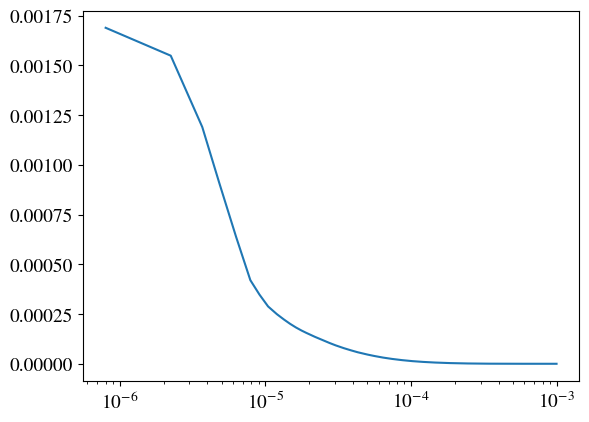

In [174]:
plt.semilogx(ekem.freq_r, og)